In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

%matplotlib inline
np.random.seed(1)

In [2]:
iris = load_iris()
x = iris.data
y = iris.target.reshape(-1, 1)

perm = np.random.permutation(y.size)
x = x[perm][:]
y = y[perm][:]

encoder = OneHotEncoder(categories='auto', dtype=np.int)
y = encoder.fit_transform(y).toarray()

scalar = MinMaxScaler()
x = scalar.fit_transform(x)

print(x.shape, y.shape)

(150, 4) (150, 3)


In [3]:
class NeuralNetwork():
    def __init__(self, x, y, lr, params={}):
        self.x = x
        self.y = y
        self.lr = lr
        
        self.activation = self.relu if 'activation' in params and params['activation'] == 'relu' else self.tanh
        self.activation_prime = self.relu_prime if 'activation' in params and params['activation'] == 'relu' else self.tanh_prime
        
        self.layer1n = params['layer1n'] if 'layer1n' in params else 4
        self.layer2n = params['layer2n'] if 'layer2n' in params else 8
        self.outputn = iris.target_names.size
        
        self.layer1weights = self.random_initialize(self.layer1n, self.x.shape[0])
        self.layer2weights = self.random_initialize(self.layer2n, self.layer1weights.shape[0])
        self.outputWeights = self.random_initialize(self.outputn, self.layer2weights.shape[0])

        self.layer1b = self.random_initialize(1, 1)
        self.layer2b = self.random_initialize(1, 1)
        self.outputb = self.random_initialize(1, 1)
        
        print('total trainable params: ', self.total_trainable_params())
        
    def random_initialize(self, *args):
        return 2 * np.random.rand(*args) - 1
        
    def sigmoid(self, x):
        z = np.exp(x - np.max(x))
        return z / z.sum(axis=0)
    
    def sigmoid_prime(self, x):
        return x * (1-x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_prime(self, x):
        return 1-(np.tanh(x)**2)
    
    def relu(self, x):
        return x * (x>0)
    
    def relu_prime(self, x):
        return np.where(x > 0, 1.0, 0.0)
    
    def loss(self, x):
        return np.mean(-self.y * np.log(x) - (1-self.y) * np.log(1-x))
    
    def loss_prime(self, x):
        return -(self.y/x) + ((1-self.y)/(1-x))
    
    def total_trainable_params(self):
        total = 0
        total += self.layer1b.size + self.layer2b.size + self.outputb.size
        total += self.layer1weights.size + self.layer2weights.size + self.outputWeights.size
        return total
    
    def forward_pass(self, x, probs=False):
        layer1 = self.activation(np.dot(self.layer1weights, x) + self.layer1b)
        layer2 = self.activation(np.dot(self.layer2weights, layer1) + self.layer2b)
        output = self.sigmoid(np.dot(self.outputWeights, layer2) + self.outputb)
        
        if probs:
            output = output.T
            for i in range(output.shape[0]):
                temp = np.zeros(3)
                temp[np.argmax(output[i])] = 1
                output[i] = temp
            
            output = output.astype(np.int)
        
        return output
    
    def backward_pass(self, epochs):
        loss = np.zeros(epochs)
        
        for epoch in range(epochs):
            a1 = self.activation(np.dot(self.layer1weights, self.x) + self.layer1b)
            a2 = self.activation(np.dot(self.layer2weights, a1) + self.layer2b)
            a3 = self.sigmoid(np.dot(self.outputWeights, a2) + self.outputb)
            
            delta = self.loss_prime(a3) * self.sigmoid_prime(a3)
            doutputWeights = np.dot(delta, a2.T) / self.x.shape[1]
            doutputb = np.mean(delta)

            delta = np.dot(self.outputWeights.T, delta) * self.activation_prime(a2)
            dlayer2weights = np.dot(delta, a1.T) / self.x.shape[1]
            dlayer2b = np.mean(delta)

            delta = np.dot(self.layer2weights.T, delta) * self.activation_prime(a1)
            dlayer1weights = np.dot(delta, self.x.T) / self.x.shape[1]
            dlayer1b = np.mean(delta)

            self.outputWeights = self.outputWeights - self.lr * doutputWeights
            self.outputb = self.outputb - self.lr * doutputb

            self.layer2weights = self.layer2weights - self.lr * dlayer2weights
            self.layer2b = self.layer2b - self.lr * dlayer2b

            self.layer1weights = self.layer1weights - self.lr * dlayer1weights
            self.layer1b = self.layer1b - self.lr * dlayer1b
            
            loss[epoch] = self.loss(a3)
            
        return loss

total trainable params:  75
accuracy:  0.9866666666666667


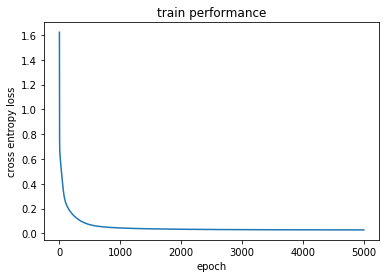

In [5]:
epochs = 5000
lr = 0.1

nn = NeuralNetwork(x.T, y.T, lr, {'activation': 'relu'})
loss = nn.backward_pass(epochs)

preds = nn.forward_pass(x.T, True)
print('accuracy: ', accuracy_score(preds, y))

plt.plot(np.arange(epochs), loss)
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('train performance')
plt.show()